<a href="https://colab.research.google.com/github/camillamelo/dog_app/blob/master/Dogs_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # To use local CPU instead of local GPU
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image 
import keras,cv2,shutil,keras_preprocessing,requests,math,glob, datetime
import tensorflow as tf
from keras import layers
from keras.models import Sequential, Model 
from keras.layers import Lambda, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, SpatialDropout2D, GlobalAveragePooling2D 
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocessor
from keras.applications.xception import Xception, preprocess_input as xception_preprocessor
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inc_resnet_preprocessor
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocessor
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_files
from io import BytesIO
import seaborn as sns
import xml.etree.ElementTree as ET
from pathlib import Path
import pickle
%load_ext tensorboard
shutil.rmtree('./logs', ignore_errors=True)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
dog_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/dogs_data/dataset/images/Images/*/*')
breeds = glob.glob('/content/drive/MyDrive/Colab Notebooks/dogs_data/dataset/annotations/Annotation/*')
annotations = glob.glob('/content/drive/MyDrive/Colab Notebooks/dogs_data/dataset/annotations/Annotation/*/*')
cropped = "/content/drive/MyDrive/Colab Notebooks/dogs_data/dataset/Cropped/"
img_size = 299 # For Xception input
train_dir = '/content/drive/MyDrive/Colab Notebooks/dogs_data/dataset/Cropped/' # './Images'
batch_size_training = 256
batch_size_validation = 256

input_shape = (img_size,img_size,3)

model_file_xception = '/content/drive/MyDrive/Colab Notebooks/dogs_data/trained_model_xception.h5'
model_file_inception = '/content/drive/MyDrive/Colab Notebooks/dogs_data/trained_model_inception.h5'


######## Plot Metrics Function ########
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

######## Read X and Y coordinate ranges from an annotation ########
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

######## Get image path from annotation path ########
def get_image(annot):
    img_path = '/content/drive/MyDrive/Colab Notebooks/dogs_data/dataset/images/Images/'
    file = annot.split('/')
#    print(file)
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    print(img_filename)
    return img_filename

######## Fill image with black to make a square (not used) ########
def make_square(im, min_size=100, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

######## Preprocess and get predictions from data with a pretrained model ########
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = keras.layers.Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    feature_extractor = Model(inputs = input_layer, outputs = GlobalAveragePooling2D()(base_model))
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

######## Concatenate all predictions on data for all pretrained models ########
def extract_all_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, input_shape, data)
    xception_features = get_features(Xception, xception_preprocessor, input_shape, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, input_shape, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, input_shape, data)
    extracted_features = np.concatenate([inception_features, xception_features, nasnet_features, inc_resnet_features],axis=-1)
    return extracted_features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
######## IMAGEDATAGENERATOR ########
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2,
    channel_shift_range=50.0,
    fill_mode='nearest'
    )

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

######## FLOW FROM DIRECTORY - TRAINING ########
train_generator = train_datagen.flow_from_directory(
    train_dir,
    seed=42,
    target_size=(img_size, img_size),
    batch_size=batch_size_training,
    subset = 'training',
    class_mode='categorical')

######## FLOW FROM DIRECTORY - VALIDATION ########
validation_generator = valid_datagen.flow_from_directory(
    train_dir,
    seed=42,
    target_size=(img_size, img_size),
    batch_size=batch_size_validation,
    subset = 'validation',
    class_mode='categorical')
num_classes = len(np.unique(train_generator.classes))

Found 17756 images belonging to 120 classes.
Found 4370 images belonging to 120 classes.


In [ ]:
train_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

## Xception

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

######## LOAD PRETRAINED MODEL ########
base_model = tf.keras.applications.Xception(
    weights = 'imagenet',
    input_shape=input_shape,
    include_top=False)
base_model.trainable = False

######## ADD NEW LAYERS TO PRETRAINED MODEL
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(base_model.input, outputs)
for layer in base_model.layers: layer.trainable = False
model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [ ]:
%%time

######### OPTIMIZER DEFINITION #########
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=5e-2,
#     decay_steps=batch_size_training // 8,
#     decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2, epsilon=1e-1)

######### MODEL COMPILATION #########
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

######### CALLBACKS #########
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='./model-{epoch:02d}-{val_accuracy:.4f}.keras', save_best_only=True, monitor='val_accuracy', mode='max')
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stoppage_callback = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001, patience=50, restore_best_weights = True)

######### TRAIN MODEL #########
history = model.fit(train_generator, 
            steps_per_epoch = math.ceil(train_generator.samples /  batch_size_training ),
            epochs=1000,
            verbose=1,
            validation_data=validation_generator, 
            validation_steps = math.ceil(validation_generator.samples /  batch_size_validation ),
            callbacks=[tensorboard_callback,early_stoppage_callback,checkpoint_callback]
            )

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/1000
70/70 [==============================] - 7472s 107s/step - loss: 4.7152 - accuracy: 0.0277 - val_loss: 4.5223 - val_accuracy: 0.1092
Epoch 2/1000
70/70 [==============================] - 398s 6s/step - loss: 4.3034 - accuracy: 0.2883 - val_loss: 4.0038 - val_accuracy: 0.5533
Epoch 3/1000
70/70 [==============================] - 394s 6s/step - loss: 3.7570 - accuracy: 0.6026 - val_loss: 3.3925 - val_accuracy: 0.7469
Epoch 4/1000
70/70 [==============================] - 396s 6s/step - loss: 3.1543 - accuracy: 0.7319 - val_loss: 2.7604 - val_accuracy: 0.8165
Epoch 5/1000
70/70 [==============================] - 396s 6s/step - loss: 2.5697 - accuracy: 0.7846 - val_loss: 2.1796 - val_accuracy: 0.8469
Epoch 6/1000
70/70 [==============================] - 397s 6s/step - loss: 2.0624 - accuracy: 0.8148 - val_loss: 1.7020 - val_accuracy: 0.8670
Epoch 7/1000
70/70 [==============================] - 396s 6s/step - loss: 1.6568 - accuracy: 0.8337 - val_loss: 1.3443 - val_accuracy: 0.8

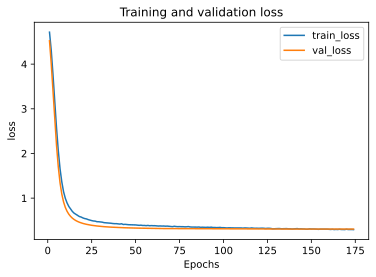

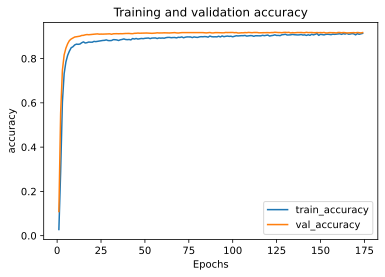

In [ ]:
plot_metric(history, "loss")
plot_metric(history, "accuracy")

In [ ]:
preds = model.predict(validation_generator,validation_generator.samples // batch_size_validation)
preds_cls_idx = preds.argmax(axis=-1)
score = model.evaluate(validation_generator)
score

18/18 [==============================] - 20s 1s/step - loss: 0.3079 - accuracy: 0.9188


[0.30794018507003784, 0.9187642931938171]

In [ ]:
tf.keras.models.save_model(model, model_file_xception)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


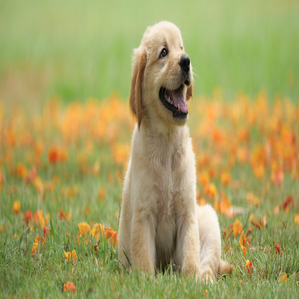

Prediction: n02099601-golden_retriever
Percentage: 65.21 %


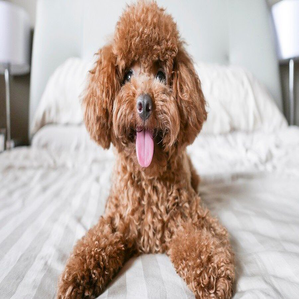

Prediction: n02113624-toy_poodle
Percentage: 91.60 %


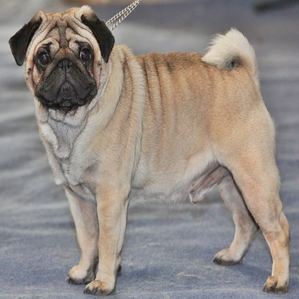

Prediction: n02110958-pug
Percentage: 99.10 %


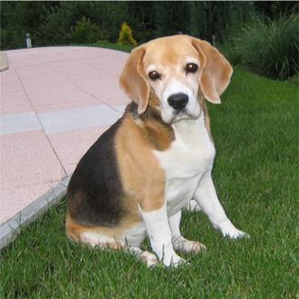

Prediction: n02088364-beagle
Percentage: 85.37 %


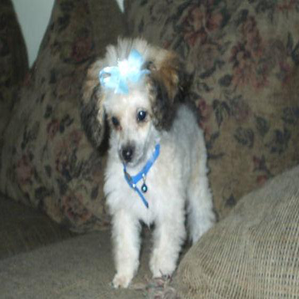

Prediction: n02113624-toy_poodle
Percentage: 65.32 %


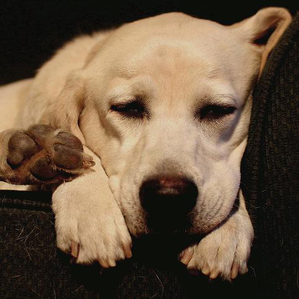

Prediction: n02099712-Labrador_retriever
Percentage: 93.58 %


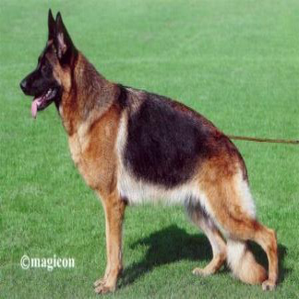

Prediction: n02106662-German_shepherd
Percentage: 98.86 %


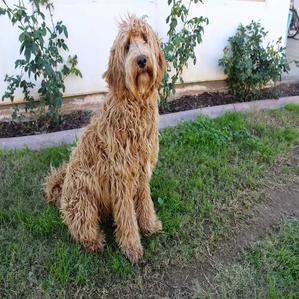

Prediction: n02091635-otterhound
Percentage: 55.34 %


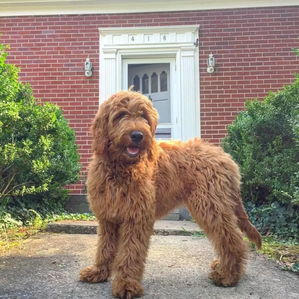

Prediction: n02105251-briard
Percentage: 52.89 %


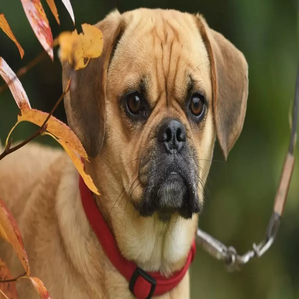

Prediction: n02108089-boxer
Percentage: 56.71 %


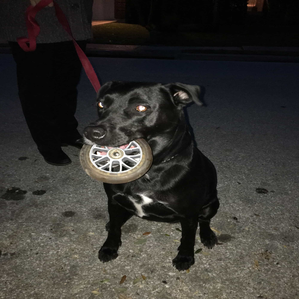

Prediction: n02099712-Labrador_retriever
Percentage: 53.73 %


In [ ]:
urls=[]
urls.append("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*")
urls.append("https://www.loveyourdog.com/wp-content/uploads/2019/04/Toy-Poodle-900x500.jpg")
urls.append("https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg")
urls.append("https://images.dog.ceo/breeds/beagle/n02088364_852.jpg")
urls.append("https://images.dog.ceo/breeds/poodle-toy/n02113624_1063.jpg")
urls.append("https://images.dog.ceo/breeds/labrador/n02099712_311.jpg")
urls.append("https://images.dog.ceo/breeds/germanshepherd/n02106662_10122.jpg")
urls.append("https://segredosdomundo.r7.com/wp-content/uploads/2019/01/conheca-10-racas-de-caes-hibridos-que-sao-resultado-de-cruzamentos-diferentes.jpg.webp")
urls.append("https://segredosdomundo.r7.com/wp-content/uploads/2019/01/conheca-10-racas-de-caes-hibridos-que-sao-resultado-de-cruzamentos-diferentes-1.jpg.webp")
urls.append("https://segredosdomundo.r7.com/wp-content/uploads/2019/01/conheca-10-racas-de-caes-hibridos-que-sao-resultado-de-cruzamento.jpg.webp")
urls.append("https://images.dog.ceo/breeds/mix/Annabelle3.jpeg")
#urls.append("https://scontent.fgig4-1.fna.fbcdn.net/v/t1.6435-9/214389907_10225296151732970_1621358362691226816_n.jpg?_nc_cat=106&ccb=1-3&_nc_sid=0debeb&_nc_eui2=AeHz4b4WViIlaP4TTYpl17o2t-iSEXVihhS36JIRdWKGFAyydsNpNuIB1FIlg61g-Js&_nc_ohc=-tDXBEEp6dkAX_bbS0y&_nc_ht=scontent.fgig4-1.fna&oh=fc882192a61b0bdf6b02cda16fb7de0d&oe=60FCC601")
#urls.append("https://scontent.fgig4-1.fna.fbcdn.net/v/t1.6435-9/217415674_10225296152612992_5998295680136712909_n.jpg?_nc_cat=102&ccb=1-3&_nc_sid=0debeb&_nc_eui2=AeGAz87KnIVmndE0YrJ2PwRg8ViUXeRmzQTxWJRd5GbNBO0v2Zj7B7tWLIUU2FYZJgg&_nc_ohc=NJsgK9x5LOcAX-3jeIE&_nc_ht=scontent.fgig4-1.fna&oh=ce68db32a85c3c31edbbb0a561054f5b&oe=60FD4C4F")
#urls.append("https://scontent.fgig4-1.fna.fbcdn.net/v/t1.6435-9/217391458_10225296153253008_7231889805198564053_n.jpg?_nc_cat=100&ccb=1-3&_nc_sid=0debeb&_nc_eui2=AeFOKSwZPirCc-Kpap0xIJcHPd3VfjjeJOI93dV-ON4k4jOec2pxb-P6l1GOfCZ1n7I&_nc_ohc=CXOXwc9PUeAAX_MwjRY&_nc_ht=scontent.fgig4-1.fna&oh=2e2ef49109fb5f80a32c3bf2841bc8fa&oe=60FC68CE")
for url in urls:
    googled_dog = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
    googled_dog = googled_dog.resize((img_size,img_size), Image.ANTIALIAS)
    display(googled_dog)
    googled_dog = np.asarray(googled_dog)/255
    googled_dog = googled_dog.reshape(1,img_size,img_size,3)
    predicted_dog = model.predict(googled_dog)
    predictedindex = predicted_dog.argmax(axis=-1)
    my_dict = train_generator.class_indices
    print('Prediction:', list(my_dict.keys())[list(my_dict.values()).index(predictedindex)])
    print('Percentage:', '{0:.2f}'.format(float(predicted_dog[0][predictedindex]*100)), '%')

#Inception V3

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

######## LOAD PRETRAINED MODEL ########
base_model = tf.keras.applications.InceptionV3(
    weights = 'imagenet',
    input_shape=input_shape,
    include_top=False)
base_model.trainable = False

######## ADD NEW LAYERS TO PRETRAINED MODEL
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
modeliv3 = tf.keras.Model(base_model.input, outputs)
for layer in base_model.layers: layer.trainable = False
modeliv3.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
%%time

######### OPTIMIZER DEFINITION #########
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=5e-2,
#     decay_steps=batch_size_training // 8,
#     decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2, epsilon=1e-1)

######### MODEL COMPILATION #########
modeliv3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

######### CALLBACKS #########
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='./modeliv3-{epoch:02d}-{val_accuracy:.4f}.keras', save_best_only=True, monitor='val_accuracy', mode='max')
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stoppage_callback = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001, patience=15, restore_best_weights = True)

######### TRAIN MODEL #########
history = modeliv3.fit(train_generator, 
            steps_per_epoch = math.ceil(train_generator.samples /  batch_size_training ),
            epochs=1000,
            verbose=1,
            validation_data=validation_generator, 
            validation_steps = math.ceil(validation_generator.samples /  batch_size_validation ),
            callbacks=[tensorboard_callback,early_stoppage_callback,checkpoint_callback]
            )

Epoch 1/1000
70/70 [==============================] - 7057s 102s/step - loss: 4.7713 - accuracy: 0.0323 - val_loss: 4.1603 - val_accuracy: 0.2396
Epoch 2/1000
70/70 [==============================] - 395s 6s/step - loss: 3.8076 - accuracy: 0.2584 - val_loss: 3.0251 - val_accuracy: 0.7240
Epoch 3/1000
70/70 [==============================] - 392s 6s/step - loss: 2.7244 - accuracy: 0.5795 - val_loss: 1.9601 - val_accuracy: 0.8357
Epoch 4/1000
70/70 [==============================] - 390s 6s/step - loss: 1.8663 - accuracy: 0.7182 - val_loss: 1.2611 - val_accuracy: 0.8654
Epoch 5/1000
70/70 [==============================] - 390s 6s/step - loss: 1.3395 - accuracy: 0.7741 - val_loss: 0.8845 - val_accuracy: 0.8824
Epoch 6/1000
70/70 [==============================] - 389s 6s/step - loss: 1.0689 - accuracy: 0.7982 - val_loss: 0.6904 - val_accuracy: 0.8881
Epoch 7/1000
70/70 [==============================] - 389s 6s/step - loss: 0.9065 - accuracy: 0.8083 - val_loss: 0.5814 - val_accuracy: 0.8

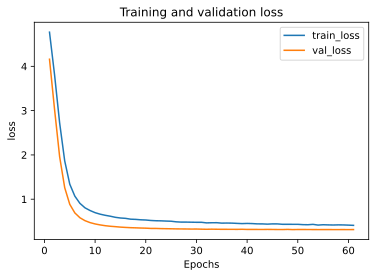

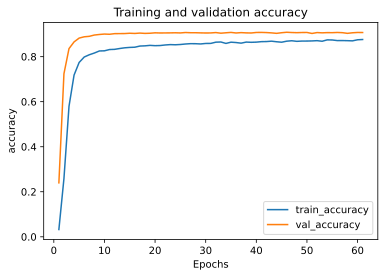

In [ ]:
plot_metric(history, "loss")
plot_metric(history, "accuracy")

In [ ]:
preds = modeliv3.predict(validation_generator,validation_generator.samples // batch_size_validation)
preds_cls_idx = preds.argmax(axis=-1)
score = modeliv3.evaluate(validation_generator)
score

18/18 [==============================] - 20s 1s/step - loss: 0.3153 - accuracy: 0.9082


[0.31527644395828247, 0.9082379937171936]

In [ ]:
#with open(model_file_inception, 'wb') as fid:
#    pickle.dump(modeliv3, fid)

tf.keras.models.save_model(modeliv3, model_file_inception)

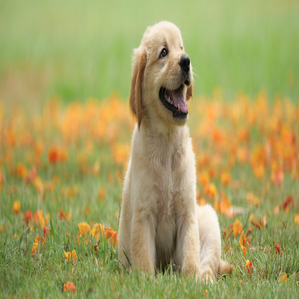

Prediction: n02099601-golden_retriever
Percentage: 84.26 %


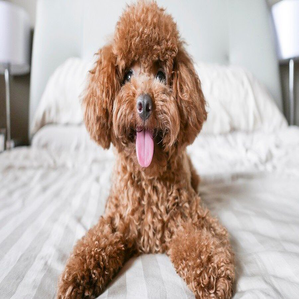

Prediction: n02113624-toy_poodle
Percentage: 88.20 %


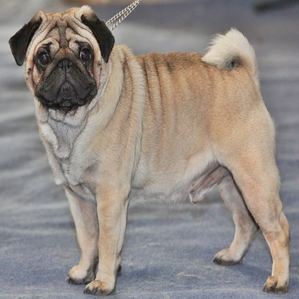

Prediction: n02110958-pug
Percentage: 97.83 %


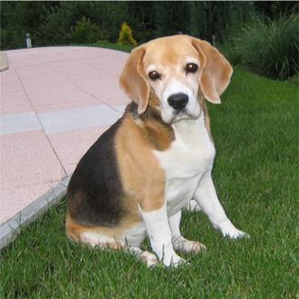

Prediction: n02088364-beagle
Percentage: 93.13 %


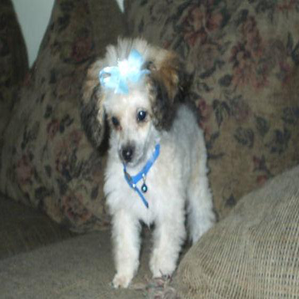

Prediction: n02086240-Shih-Tzu
Percentage: 40.51 %


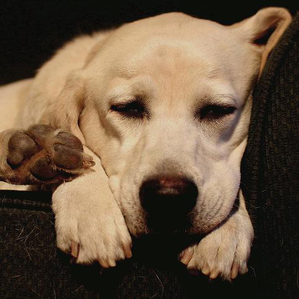

Prediction: n02099712-Labrador_retriever
Percentage: 97.93 %


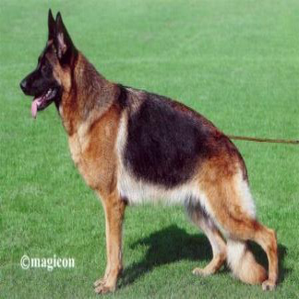

Prediction: n02106662-German_shepherd
Percentage: 98.89 %


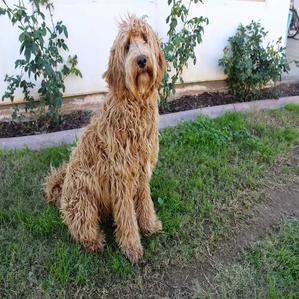

Prediction: n02091635-otterhound
Percentage: 98.03 %


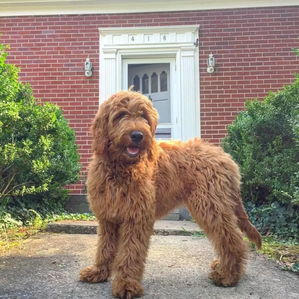

Prediction: n02105251-briard
Percentage: 38.82 %


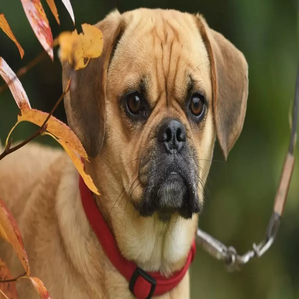

Prediction: n02108422-bull_mastiff
Percentage: 76.83 %


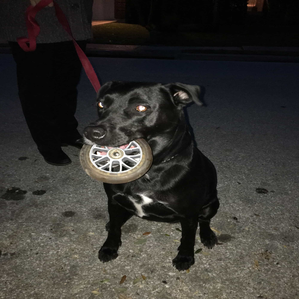

Prediction: n02099712-Labrador_retriever
Percentage: 61.30 %


In [ ]:
urls=[]
urls.append("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*")
urls.append("https://www.loveyourdog.com/wp-content/uploads/2019/04/Toy-Poodle-900x500.jpg")
urls.append("https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg")
urls.append("https://images.dog.ceo/breeds/beagle/n02088364_852.jpg")
urls.append("https://images.dog.ceo/breeds/poodle-toy/n02113624_1063.jpg")
urls.append("https://images.dog.ceo/breeds/labrador/n02099712_311.jpg")
urls.append("https://images.dog.ceo/breeds/germanshepherd/n02106662_10122.jpg")
urls.append("https://segredosdomundo.r7.com/wp-content/uploads/2019/01/conheca-10-racas-de-caes-hibridos-que-sao-resultado-de-cruzamentos-diferentes.jpg.webp")
urls.append("https://segredosdomundo.r7.com/wp-content/uploads/2019/01/conheca-10-racas-de-caes-hibridos-que-sao-resultado-de-cruzamentos-diferentes-1.jpg.webp")
urls.append("https://segredosdomundo.r7.com/wp-content/uploads/2019/01/conheca-10-racas-de-caes-hibridos-que-sao-resultado-de-cruzamento.jpg.webp")
urls.append("https://images.dog.ceo/breeds/mix/Annabelle3.jpeg")
#urls.append("https://scontent.fgig4-1.fna.fbcdn.net/v/t1.6435-9/214389907_10225296151732970_1621358362691226816_n.jpg?_nc_cat=106&ccb=1-3&_nc_sid=0debeb&_nc_eui2=AeHz4b4WViIlaP4TTYpl17o2t-iSEXVihhS36JIRdWKGFAyydsNpNuIB1FIlg61g-Js&_nc_ohc=-tDXBEEp6dkAX_bbS0y&_nc_ht=scontent.fgig4-1.fna&oh=fc882192a61b0bdf6b02cda16fb7de0d&oe=60FCC601")
#urls.append("https://scontent.fgig4-1.fna.fbcdn.net/v/t1.6435-9/217415674_10225296152612992_5998295680136712909_n.jpg?_nc_cat=102&ccb=1-3&_nc_sid=0debeb&_nc_eui2=AeGAz87KnIVmndE0YrJ2PwRg8ViUXeRmzQTxWJRd5GbNBO0v2Zj7B7tWLIUU2FYZJgg&_nc_ohc=NJsgK9x5LOcAX-3jeIE&_nc_ht=scontent.fgig4-1.fna&oh=ce68db32a85c3c31edbbb0a561054f5b&oe=60FD4C4F")
#urls.append("https://scontent.fgig4-1.fna.fbcdn.net/v/t1.6435-9/217391458_10225296153253008_7231889805198564053_n.jpg?_nc_cat=100&ccb=1-3&_nc_sid=0debeb&_nc_eui2=AeFOKSwZPirCc-Kpap0xIJcHPd3VfjjeJOI93dV-ON4k4jOec2pxb-P6l1GOfCZ1n7I&_nc_ohc=CXOXwc9PUeAAX_MwjRY&_nc_ht=scontent.fgig4-1.fna&oh=2e2ef49109fb5f80a32c3bf2841bc8fa&oe=60FC68CE")
for url in urls:
    googled_dog = Image.open(BytesIO(requests.get(url).content)).convert("RGB")
    googled_dog = googled_dog.resize((img_size,img_size), Image.ANTIALIAS)
    display(googled_dog)
    googled_dog = np.asarray(googled_dog)/255
    googled_dog = googled_dog.reshape(1,img_size,img_size,3)
    predicted_dog = modeliv3.predict(googled_dog)
    predictedindex = predicted_dog.argmax(axis=-1)
    my_dict = train_generator.class_indices
    print('Prediction:', list(my_dict.keys())[list(my_dict.values()).index(predictedindex)])
    print('Percentage:', '{0:.2f}'.format(float(predicted_dog[0][predictedindex]*100)), '%')